In [1]:
import numpy as np
import matplotlib.pyplot as plt

from uot import UOT, EntRegUOT
from uot import exact_uot, exact_entreg_uot
from uot import calc_B, calc_f, calc_g
from sinkhorn import calc_R, calc_U, sinkhorn_entreg_uot, sinkhorn
from utils import norm_inf

np.random.seed(3698)

## Experiments

### Varying epsilon (Synthetic Data)

#### Preparation

In [ ]:
# Dimension
n = 10

# Regularization
tau = np.float64(5.0)

# Mass normalization
alpha = 2.0
beta = 4.0

# Number of eps
neps = 20

In [ ]:
np.random.seed(3698)

# Cost matrix
C = np.random.uniform(low=1.0, high=50.0, size=(n, n)).astype(np.float64)
C = (C + C.T) / 2.0

# Marginal vectors
a = np.random.uniform(0.1, 1.0, size=n).astype(np.float64)
b = np.random.uniform(0.1, 1.0, size=n).astype(np.float64)

a = a / a.sum() * alpha
b = b / b.sum() * beta

#### Execution

In [ ]:
# Original UOT problem
uot_p = UOT(C, a, b, tau)

# Optimal solution
f_optimal, X_optimal = exact_uot(uot_p)

print('Optimal:', f_optimal)

In [ ]:
# Epsilons
eps_arr = np.linspace(start=1.0, stop=0.05, num=neps).astype(np.float64)

kfs, kcs = np.zeros((2, neps))

for i, eps in enumerate(eps_arr):
    # Entropic regularization parameter
    U = calc_U(uot_p, eps)
    eta = eps / U

    # Convert to Entropic Regularized UOT
    p = EntRegUOT(C, a, b, tau, eta)

    # Sinkhorn
    _, log = sinkhorn_entreg_uot(p, eps)

    # Find kf
    kf = log['k_stop']

    # Find kc
    f_approx = np.array([
        calc_f(p, calc_B(p, u, v))
        for u, v in zip(log['u'], log['v'])
    ])
    kc = np.where(f_approx - f_optimal > eps)[0][-1]

    kfs[i] = kf
    kcs[i] = kc + 2

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5), dpi=100)

ax[0].plot(eps_arr, np.log(kcs), label='\log k_f')
ax[0].plot(eps_arr, np.log(kfs), label='\log k_c')
ax[0].set_xlim(1.0 + 0.05, 0 - 0.05)

ax[1].plot(eps_arr, kfs / kcs, label='\log k_f')
ax[1].set_xlim(1.0 + 0.05, 0 - 0.05)

### Theory check (Synthetic data)

#### Preparation

In [2]:
# Dimension
n = 100

# Regularization
tau = np.float64(1.0)
eta = np.float64(0.05)

# Number of Sinkhorn iterations
niters = 500

In [3]:
np.random.seed(3698)

# Cost matrix
C = np.random.uniform(low=1.0, high=100.0, size=(n, n)).astype(np.float64)
C = (C + C.T) / 2.0

# Marginal vectors
a = np.random.uniform(0.1, 10.0, size=n).astype(np.float64)
b = np.random.uniform(0.1, 10.0, size=n).astype(np.float64)

UOT problem

In [4]:
uot_p = UOT(C, a, b, tau)

In [5]:
f_best, X_hat = exact_uot(uot_p)

Entropic regularized UOT problem

In [6]:
p = EntRegUOT(C, a, b, tau, eta)

In [7]:
g_best, u_opt, v_opt = exact_entreg_uot(p)

In [8]:
X_star = calc_B(p, u_opt, v_opt)
a_star = X_star.sum(-1)
b_star = X_star.sum(0)

Solve with Sinkhorn iterations

In [9]:
_, log = sinkhorn(p, niters - 1)

#### Lemma 1

$$
\frac{u^*}{\tau} = \log(a) - \log(a^*) \\
\frac{v^*}{\tau} = \log(b) - \log(b^*)
$$

0.0014643020164619713


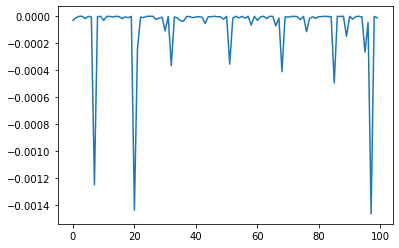

In [10]:
print(norm_inf(u_opt / tau - np.log(a / a_star)))

plt.plot(u_opt / tau - np.log(a / a_star))
plt.show()

0.002263160043399992


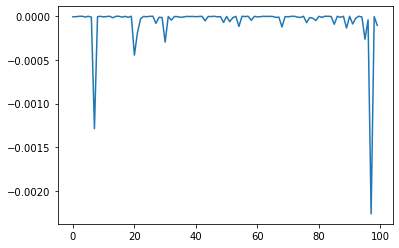

In [11]:
print(norm_inf(v_opt / tau - np.log(b / b_star)))

plt.plot(v_opt / tau - np.log(b / b_star))
plt.show()

#### Lemma 2

$$
\Big| \log\left( \frac{a_i^*}{a_i^k} \right) -  \frac{u_i^* - u_i^k}{\eta}\Big| \leq  \max_{1 \leq j \leq n} \frac{|v^*_j - v^{k}_j|}{\eta}
$$

$$
\Big| \log\left( \frac{b_j^*}{b_j^k} \right) -  \frac{v_j^* - v_j^k}{\eta}\Big| \leq  \max_{1 \leq i \leq n} \frac{|u^*_i - u^{k}_i|}{\eta}
$$

-1.7763568394002505e-14


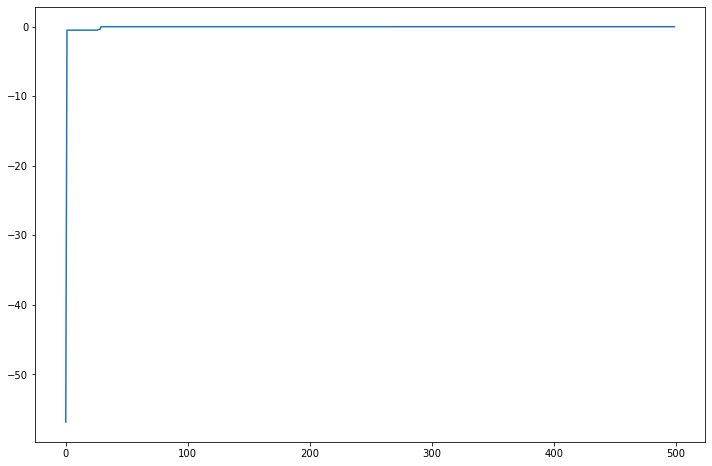

In [12]:
lhs, rhs = np.zeros((2, niters))

for k, (uk, vk) in enumerate(zip(log['u'], log['v'])):
    X = calc_B(p, uk, vk)
    ak = X.sum(-1)

    l = norm_inf(np.log(a_star / ak) - (u_opt - uk) / eta)
    r = norm_inf((v_opt - vk) / eta)

    lhs[k], rhs[k] = l, r

print(np.max(lhs - rhs))

plt.figure(figsize=(12, 8))
plt.plot(range(niters), lhs - rhs)
plt.show()

2.3440450969136606e-16


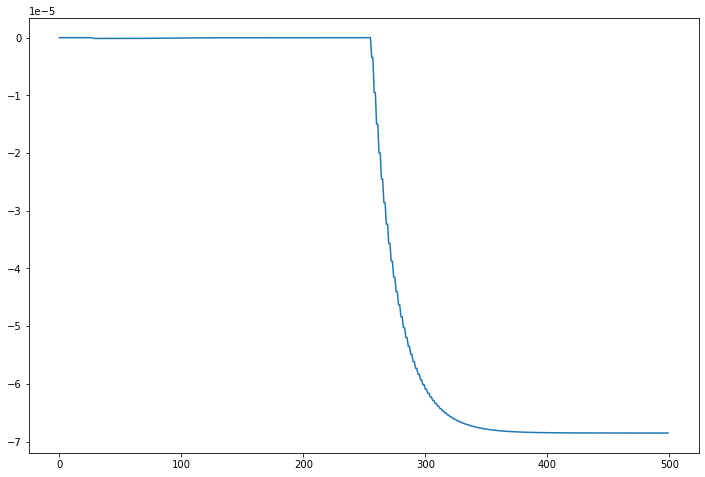

In [13]:
lhs, rhs = np.zeros((2, niters))

for k, (uk, vk) in enumerate(zip(log['u'], log['v'])):
    X = calc_B(p, uk, vk)
    bk = X.sum(0)

    l = norm_inf(np.log(b_star / bk) - (v_opt - vk) / eta)
    r = norm_inf((u_opt - uk) / eta)

    lhs[k], rhs[k] = l, r

print(np.max(lhs - rhs))

plt.figure(figsize=(12, 8))
plt.plot(range(niters), lhs - rhs)
plt.show()

#### Lemma 3

$$
\max \{ \|u^*\|_{\infty},\|v^*\|_\infty \} \le \tau R
$$

In [14]:
R = calc_R(p)

In [15]:
lhs = max(norm_inf(u_opt), norm_inf(v_opt))
rhs = tau * R
print(lhs - rhs)

-1964.6588971439326


#### Lemma 4

$$
g(X^*) + (2 \tau + \eta) x^* = \tau (\alpha + \beta) \\
f(\hat{X}) + 2 \tau \hat{x} = \tau (\alpha + \beta)
$$

In [16]:
alpha, beta = a.sum(), b.sum()

In [17]:
calc_g(p, u_opt, v_opt)

937.9720594999625

In [21]:
lhs1 = calc_g(p, u_opt, v_opt) + (2 * tau + eta) * np.sum(X_star)
lhs2 = f_best + 2 * tau * np.sum(X_hat)
rhs = tau * (alpha + beta)
print(lhs1 - rhs)
print(lhs2 - rhs)

-0.00015324840353514446
5.153232859811396e-05


#### Theorem 1

$$
\max \{ \| u^{k} -  u^*\|_\infty, \| v^{k} -  v^*\|_\infty \} \le \Big( \frac{\tau}{\tau + \eta} \Big)^k \times \tau \times R
$$

In [19]:
R = calc_R(p)

0.00010433620048765733


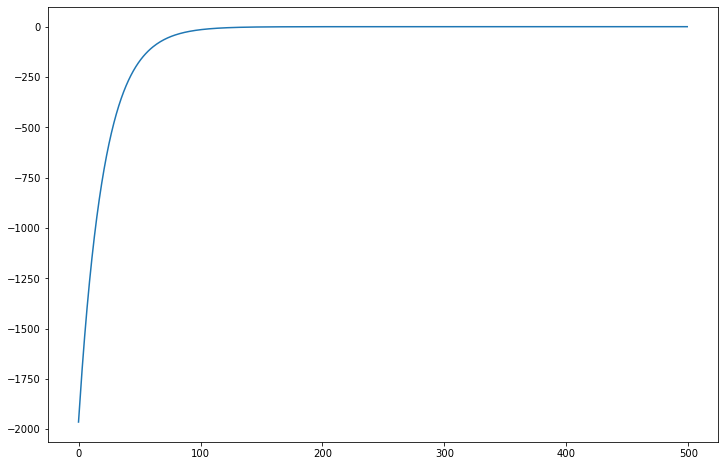

In [20]:
lhs, rhs = np.zeros((2, niters))

for k, (uk, vk) in enumerate(zip(log['u'], log['v'])):
    X = calc_B(p, uk, vk)
    bk = X.sum(0)

    l = max(norm_inf(uk - u_opt), norm_inf(vk - v_opt))
    r = (tau / (tau + eta)) ** k * tau * R

    lhs[k], rhs[k] = l, r

print(np.max(lhs - rhs))

plt.figure(figsize=(12, 8))
plt.plot(range(niters), lhs - rhs)
plt.show()